In [7]:
import argparse
import yaml
import torch
import time
import shutil
import os
import copy

from dataset import SkillDataSet
from model import RAAN

from addict import Dict
from torch import nn
import torch.nn.functional
from torch.utils.tensorboard import SummaryWriter

os.environ["CUDA_VISIBLE_DEVICES"] = "4"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Dict(yaml.safe_load(open(os.path.join('args','test.yaml'))))

In [8]:
validset = SkillDataSet("data/BEST/features/tie_tie", "data/BEST/splits/tie_tie/test.txt", ftr_tmpl='{}_{}.npz')

In [9]:
valid_loader = torch.utils.data.DataLoader(validset,batch_size=4,shuffle=False,num_workers=4,pin_memory=True)
iterator = iter(valid_loader)

In [10]:
models = {'pos': None, 'neg': None}
for k in models.keys():
    models[k] = RAAN(args)
    models[k] = models[k].to(device)

In [11]:
attention_params = []
model_params = []
for model in models.values():
    for name, param in model.named_parameters():
        if param.requires_grad and 'att' in name:
            attention_params.append(param)
        else:
            model_params.append(param)
            print(name)

tcn.conv_1x1.weight
tcn.conv_1x1.bias
tcn.layers.0.conv_dilated.weight
tcn.layers.0.conv_dilated.bias
tcn.layers.0.conv_1x1.weight
tcn.layers.0.conv_1x1.bias
tcn.layers.1.conv_dilated.weight
tcn.layers.1.conv_dilated.bias
tcn.layers.1.conv_1x1.weight
tcn.layers.1.conv_1x1.bias
tcn.layers.2.conv_dilated.weight
tcn.layers.2.conv_dilated.bias
tcn.layers.2.conv_1x1.weight
tcn.layers.2.conv_1x1.bias
tcn.layers.3.conv_dilated.weight
tcn.layers.3.conv_dilated.bias
tcn.layers.3.conv_1x1.weight
tcn.layers.3.conv_1x1.bias
tcn.layers.4.conv_dilated.weight
tcn.layers.4.conv_dilated.bias
tcn.layers.4.conv_1x1.weight
tcn.layers.4.conv_1x1.bias
tcn.layers.5.conv_dilated.weight
tcn.layers.5.conv_dilated.bias
tcn.layers.5.conv_1x1.weight
tcn.layers.5.conv_1x1.bias
tcn.layers.6.conv_dilated.weight
tcn.layers.6.conv_dilated.bias
tcn.layers.6.conv_1x1.weight
tcn.layers.6.conv_1x1.bias
tcn.layers.7.conv_dilated.weight
tcn.layers.7.conv_dilated.bias
tcn.layers.7.conv_1x1.weight
tcn.layers.7.conv_1x1.bias
tc

In [6]:
model_uniform = RAAN(args, uniform = True)
model_uniform = model_uniform.to(device)

In [6]:
for k in models.keys():
        models[k].train()
model_uniform.train()

RAAN(
  (tcn): SingleStageTCN(
    (conv_1x1): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
    (layers): ModuleList(
      (0): DilatedResidualLayer(
        (conv_dilated): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv_1x1): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (1): DilatedResidualLayer(
        (conv_dilated): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (conv_1x1): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (2): DilatedResidualLayer(
        (conv_dilated): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (conv_1x1): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (3): DilatedResidualLayer(
        (conv_dilated): Conv1d(1024, 1024, kernel_size=(3,), stride=(1

In [7]:
input1, input2, vidlist = next(iterator)
input1_gpu = input1.to(device)
input2_gpu = input2.to(device)

In [8]:
vidlist

{'pos': ['DqpQ_a0ckbI', 'DqpQ_a0ckbI', 'GejdxPPI8Xk', '8R0zwW3gLfA'],
 'neg': ['EJPgVjGMft8', 'w-YOXprrN_0', 'vT303TcQUAA', 'drQAMREwmGo']}

In [9]:
labels = torch.ones(input1.size(0))
target = labels.to(device)

In [10]:
all_output1, all_output2, output1, output2, att1, att2 = {}, {}, {}, {}, {}, {}
for k in models.keys():
    all_output1[k], att1[k] = models[k](input1_gpu)
    all_output2[k], att2[k] = models[k](input2_gpu)
    output1[k] = all_output1[k].mean(dim=1)
    output2[k] = all_output2[k].mean(dim=1)

In [11]:
# uniform model
output1_uniform, _ = model_uniform(input1_gpu)
output2_uniform, _ = model_uniform(input2_gpu)
output1_uniforms = output1_uniform.mean(dim=1)
output2_uniforms = output2_uniform.mean(dim=1)

In [12]:
output1['pos']

tensor([0.4311, 0.4311, 0.4305, 0.3161], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [12]:
def multi_rank_loss(input_a_1, input_a_2, input_b_1, input_b_2, target, margin, device, version):
    if version == "v1":
        inter1, _ = torch.min((input_a_1 - input_a_2), dim=1)
    elif version == "v2":
        inter1 = (input_a_1.mean(dim=1) - input_a_2.mean(dim=1))
    inter2 = (input_b_1 - input_b_2)
    inter = -target * (inter1.view(-1) - inter2.view(-1)) + torch.ones(input_a_1.size(0)).to(device)*margin
    losses = torch.max(torch.zeros(input_a_1.size(0)).to(device), inter)
    return losses.sum()/input_a_1.size(0)

In [13]:
d_loss_2 = multi_rank_loss(all_output1['pos'], all_output2['pos'], output1_uniform,
                                                output2_uniform, target, 0.5, device, "v2")
d_loss_2

tensor(0.2281, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
# Eval

In [30]:
a1 = at1[:,::6]
a2 = at2[:,::5]

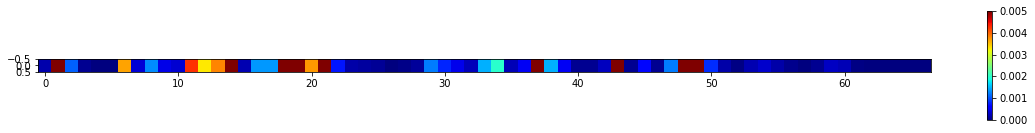

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# ヒートマップ表示
plt.figure(figsize=(20,2))
plt.imshow(a1,interpolation='nearest',vmin=0,vmax=1/200,cmap='jet')
plt.colorbar()
plt.show()

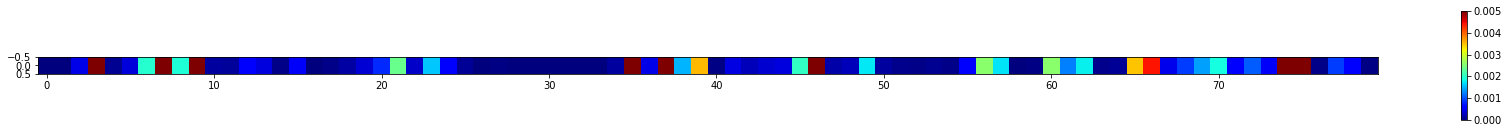

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# ヒートマップ表示
plt.figure(figsize=(30,2))
plt.imshow(a2,interpolation='nearest',vmin=0,vmax=1/200,cmap='jet')
plt.colorbar()
plt.show()